In [10]:
# -*- coding: utf-8 -*-
"""
Titulo: Automatizacion reportes regionales (V3)
Created on Fri Dic 2 16:24:52 2023

Proceso que automatiza reportes regionales, generando un documento word por cada region a partir de template y Base de datos.

Obs: Se deben revisar los inputs antes de correr
     Refinar funciones
     Eliminar librerías sin uso

@author: diego.martinez
"""

# =============================================================================
# Extracción en python de datos de comunicado de compras a nivel regional
# =============================================================================

#Seteo de librerias

import pandas as pd
import numpy as np
import sqlalchemy as sa              #Para conexión a BD, requerido para usar pd.read_sql()
import urllib                        #Para formatear string de conexión

import docx
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches
import openpyxl as opxl             # OJO EN LA CASA para importar excel como dataframe

from docx import Document
from docx.shared import Inches
from docxtpl import DocxTemplate, InlineImage   #rellenar templates

import os
from pylab import savefig
import itertools

import pyodbc                               ### another engine to make DB connection and run the queries. Alternative to sqlalchemy
from itertools import repeat
import querysGR as qg

In [2]:
#Transforma codigo a word
#Agregar github


#Conexion a DW

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#param = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022")#;Trusted_Connection=yes
#conn = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param)

#A DCCPProcurement
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.145;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)
#paramAQ = urllib.parse.quote_plus("DRIVER={ODBC Driver 13 for SQL Server};SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse")
#bd = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramAQ)


#**** BBDD *****

# Verificar Drivers

###### DW ######

param_DW = urllib.parse.quote_plus("DRIVER={SQL Server};SERVER=10.34.71.202;UID=datawarehouse;PWD=datawarehouse;DATABASE=DM_Transaccional;TrustServerCertificate=yes")
conn_DW = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_DW)


##### DEV #####

param_dev = urllib.parse.quote_plus("DRIVER={/opt/microsoft/msodbcsql18/lib64/libmsodbcsql-18.2.so.2.1};SERVER=10.34.71.227;UID=eymetric;PWD=Eym3tr1c.2022;DATABASE=DM_Transaccional_2022;TrustServerCertificate=yes")
conn_dev = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_dev)

##### AQUILES #####

param_AQ = urllib.parse.quote_plus("DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes")
conn_AQ = sa.create_engine("mssql+pyodbc:///?odbc_connect=%s" % param_AQ)

### connections with pyodbc ###
conn_AQ_pyodbc=pyodbc.connect('DRIVER={SQL Server};DATABASE=DCCPProcurement;SERVER=10.34.71.146;UID=datawarehouse;PWD=datawarehouse;DATABASE=DCCPProcurement;TrustServerCertificate=yes')#;Encrypt=yes')#;TrustServerCertificate=yes')#;TrustServerCertificate=yes')
#conn_AQ_pyodbc = pyodbc.connect('DRIVER={SQL Server};SERVER=10.34.71.146;DATABASE=DCCPProcurement;UID=datawarehouse;PWD=datawarehouse')
cursor=conn_AQ_pyodbc.cursor()
#*************************

In [3]:
###########################################
###########################################
######                               ######
######       Definir Funciones       ######
######                               ######
###########################################
###########################################


#entra numero y retorna valor con puntos en string
#abrevia en millones si supera 8 dígitos
#agrega símbolos monetarios
def fmtoEntero(x, mnd=''):
    ini = ''
    fin = ''

    #abrevia si supera 8 digitos
    if x >= 100000000: #me pareció que muestre al menos 3 dígitos
        x = x / 1000000
        fin = ' millones'
    
    #verificar formato de escritura
    if mnd == 'CLP':
        ini = '$'
    elif mnd == 'USD':
        ini = 'US $'
        #fin = fin + ' USD'
    elif mnd == 'CLF':
        if fin == ' millones':
            fin = fin + ' de UF'
        else:
            fin = fin + ' UF'
    
    x = format(int(round(x)),',d') #crea str de entero con puntuación
    x = x.replace(",",".") #formato de puntos latino

    return ini + x + fin


#entra tasa y retorna el porcentaje como string
def fmtoPorcien(x):
    x = x * 100
    x = format(x,',.1f') #crea str con 1 decimal y puntuación
    x = x.replace(".","a").replace(",",".").replace("a",",") #formato de puntos latino
    return x+'%'


#retorna string aumento/disminución según variacón numérica entregada
def palabraVar(var):
    plb = 'una no variación' #es necesario?
    if var > 0:
        plb = 'un aumento'
    elif var < 0:
        plb = 'una disminución'
    return plb



#Transforma ordenadamente datos de un dataframe a un diccionario de listas, ordenando los valores de la columna 'CLP' para graficarlos
    #Para ordenarlos usa lstArrays como primer criterio para filtrar el dataframe y para nombrar las claves de las listas del diccionario
    #Usa listaDatos como segundo criterio para filtrar dataframe y ordenar los datos dentro de las listas
    #lstaArrays y lstaDatos deben contener datos de existentes de columnas del dataframe cada uno, nombres especificados con las variabels colArrays y colDatos
    #Ej: Si tenemos el dataframe con columnas 'Año', 'Sector' y 'CLP', usamos lstaArrays [2023,  2022] con 'Año', listaDato ['FFAA', 'Salud'] con 'Sector'
    #Retornaría el siguiente diccionario:
    #{2023 : [(monto FFAA en 2023), (monto Salud en 2023)],
    # 2022 : [(monto FFAA en 2022), (monto Salud en 2022)]}
    #
    #(df = dataframe, lstaArrays = lista, colArrays = string, lstaDatos = lista, colDatos = strin)
def diccionarioGraficos(df, lstaArrays, colArrays, lstaDatos, colDatos):

    #Crea diccionario a retornar
    dic={}

    #Recorre la lstaArrays
    for i in range (0, len(lstaArrays)):

        #Agrega al diccionario elemento con el dato de lstaArrays actual como clave y una lista vacía como valor
        dic[lstaArrays[i]]=[]
        print('')
        print('Año '+str(lstaArrays[i]))

        #Recorre la lstaDatos
        for j in range (0, len(lstaDatos)):

            #Extrae del dataframe monto en CLP filtrando filas por el valor de lstaArrays y lstaDatos actuales
            #Ej: filtro 'Año' ==  2022 y 'Sector' == FFAA
            clp = df.loc[(df[colArrays]==lstaArrays[i]) & (df[colDatos]==lstaDatos[j]), 'CLP'].values[0]
            #Agrega monto a la lista de clave correspondiente en lstaArray y en la posicción correspondiente de lstaDatos
            dic[lstaArrays[i]].append(clp)

        print(dic)

    return dic



#Genera gráfico de barras agrupadas de a 3
#Requiere dic (un diccionario de listas), lstaArrays (una lista del largo de dic y que contiene las claves de dic),
        #lstaDatos (una lista del largo de las listas de dic, contiene la etiqueta y orden de los datos de las listas de dic)
        #y titulo (string que da nómbre al gráfico)
#puede modificarse para que la cantidad de de barras por etiqueta se adapte a el largo de lstaArrays
def grafBarrasTriple(dic, lstaArrays, lstaDatos, titulo):
    plt.clf()

    # set width of bar 
    barWidth = 0.25
    fig = plt.subplots(figsize =(12, 8)) 

    # Set position of bar on X axis 
    br1 = np.arange(len(dic[2023])) 
    br2 = [x + barWidth for x in br1] 
    br3 = [x + barWidth for x in br2] 
    
    # Make the plot
    plt.bar(br1, dic[lstaArrays[0]], 
            width = barWidth, 
            label =str(lstaArrays[0])) 
    plt.bar(br2, dic[lstaArrays[1]], 
            width = barWidth, 
            label =str(lstaArrays[1])) 
    plt.bar(br3, dic[lstaArrays[2]], 
            width = barWidth, 
            label =str(lstaArrays[2])) 
    
    # Adding Xticks 
    plt.xlabel(titulo, fontweight ='bold', fontsize = 15) 
    plt.ylabel('Millones de Pesos', fontweight ='bold', fontsize = 15) 
    plt.xticks([r + barWidth for r in range(len(dic[2023]))], 
            lstaDatos)
    
    plt.legend()
    plt.savefig(titulo+'.png')



#Necesita dic (diccionario) de listas, las claves indican la region, lstaDatos (lista) indica los sectores y orden de los datos en las listas de dic
def graficoSectoresRegion(dic, lstaDatos, titulo):
    plt.clf()

    #Transforma los datos de cada lista a su valor en porcentaje sobre el total de cada lista
    for key, value in dic.items():
        total = np.sum(value)
        dic[key] = np.round(np.array(value)*100/total, 1)

    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(dic.keys())
    data = np.array(list(dic.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['turbo'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(lstaDatos, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncols=len(lstaDatos), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')
    
    plt.savefig(titulo+'.png')
    return fig, ax






#Agrega gráfico de torta, necesita datos (x), etiqueta (labels) y título (titGraf)
def grafTorta(x, labels, titGraf): 
    plt.clf()
    
    fig, ax = plt.subplots(figsize =(10, 9))
    #plt.figure(figsize=(4.5,4.5))
    bordeG = {'linewidth' : 1, 'edgecolor' : 'white'}
    plt.pie(x
            , autopct='%.1f%%'
            , textprops=dict(color="grey", size=10)
            , pctdistance=1.15
            , wedgeprops = bordeG)
    legend = plt.legend(labels
                        , loc = "lower center"
                        , bbox_to_anchor=(0.27, -0.15, 0.5, 0.5)
                        , ncols = 3
                        , fontsize=10
                        , handlelength=0.7
                        , handleheight=0.7
                        ) 
    tituloG = plt.title(titGraf ,fontweight="bold",fontsize=16)

    
    plt.savefig(titGraf+'.png')



#Crea gráfico de barras horizontal, necesita datos (x), etiqueta (labels) y título (titulo)
def grafBarras(x, labels, titulo):
    plt.clf()
    fig, ax = plt.subplots(figsize =(16, 9))
    
    # Horizontal Bar Plot
    ax.barh(labels, x)
    
    # Remove axes splines
    for s in ['top', 'right']:
        ax.spines[s].set_visible(False)
    
    # Remove x, y Ticks
    #ax.xaxis.set_ticks_position('none')
    #ax.yaxis.set_ticks_position('none')
    
    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 5)
    ax.yaxis.set_tick_params(pad = 10)
    
    # Add x, y gridlines
    ax.grid(#b = True, 
            color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)
    
    # Show top values 
    ax.invert_yaxis()
    
    # Add annotation to bars
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5, 
                str(round((i.get_width()), 2)),
                fontsize = 15, fontweight ='bold',
                color ='grey')
    
    # Add Plot Title
    ax.set_title(titulo,
                loc ='left', 
                fontsize = 25)
    
    # Add Text watermark
    fig.text(0.9, 0.15, 'ChileCompra', fontsize = 12,
            color ='grey', ha ='right', va ='top',
            alpha = 0.7)
    plt.style.use('seaborn-v0_8-darkgrid')
    # Show Plot
    plt.savefig(titulo+'.png')



#Settea diccionario contexto regional, agrgando como primeros datos nombre largo y nombre corto de la región
def setContextoReg(r, regNom):
    ctxt = {}
    ctxt.update(regNom[r])
    return ctxt



#Retorna diccionario con total transado de monto y OC por región
#(dataframe filtrado por región, moneda a usar)
def agregarTotalesRegion(df):
    nctxt = {}
    
    regMndUSD   = df.loc[df['Año'] == anoReg, 'Monto_Bruto_USD'].iloc[0]     
    regMnd      = df.loc[df['Año'] == anoReg, 'Monto_Bruto_'+'CLP'].iloc[0]     
    regOC       = df.loc[df['Año'] == anoReg, 'CantOC'].iloc[0]               
    regMndM     = df.loc[df['Año'] == anoRegM, 'Monto_Bruto_'+'CLP'].iloc[0]    
    regOCM      = df.loc[df['Año'] == anoRegM, 'CantOC'].iloc[0]              

    nctxt['totRegUSD']      = fmtoEntero( regMndUSD , 'USD')
    nctxt['totReg'+'CLP']     = fmtoEntero( regMnd    , 'CLP')
    nctxt['totRegOC']       = fmtoEntero( regOC     )
    nctxt['totReg'+'CLP'+'M'] = fmtoEntero( regMndM   , 'CLP')
    nctxt['totRegOCM']      = fmtoEntero( regOCM    )
    
    tasaVar                 = (regMnd - regMndM) / regMndM
    nctxt['totRegPct']      = fmtoPorcien(tasaVar)
    nctxt['totRegVarPlb']   = palabraVar(tasaVar)

    return nctxt



#Llama a creación de gráfico y retorna diccionario para agregarlo a template
#¿Pide moneda o dejamos default?
def agregarGrafMontoSectorRegion(df, titGraf):
    
    grafTorta(df['CLP'], df[''], titGraf)
    #pedir docu como parametro?
    img = InlineImage(docu, titGraf+'.png',width=Inches(6))
    dctGrf = {'secRegGrf' : img}
    return dctGrf



def agregarCARegion(df): 
    nctxt = {}

    # Dataframes año actual y anterior
    df0 = df.loc[df['Ano'] == anoReg] #MONTOCLP_CAg  MONTOUSD_CAg  CantOC_CAg
    dfM = df.loc[df['Ano'] == anoRegM]

    mto0    = df0['MONTOCLP_CAg'].iloc[0]
    oc0     = df0['CantOC_CAg'].iloc[0]
    mtoM    = dfM['MONTOCLP_CAg'].iloc[0]
    ocM     = dfM['CantOC_CAg'].iloc[0]

    mtoVar  = (mto0 - mtoM)/ mtoM   #Variacion monto
    ocDif   = oc0 - ocM             #Diferencia cantidad OC
    
    nctxt['caReg'+'CLP']       = fmtoEntero(mto0, 'CLP')
    nctxt['caRegOC']         = fmtoEntero(oc0)
    nctxt['caReg'+'CLP'+'M']   = fmtoEntero(mtoM, 'CLP')
    nctxt['caRegOCM']        = fmtoEntero(ocM)
    nctxt['caReg'+'CLP'+'Var'] = fmtoPorcien(mtoVar)
    nctxt['caRegOCDif']      = fmtoEntero(ocDif)

    return nctxt



def extraerDataframe (df, r, listCol):
    df = df.loc[df['Region'] == r]
    listCol = ['Ano', 'Region'] + listCol
    
    df = df.groupby(listCol).agg({'USD' : sum,
                                  'CLP' : sum,
                                  'CLF' : sum,
                                  'OC'  : sum,})
    
    return df



def fmtoDataframe (df, listCol):
    df = df.reset_index()                               #reincorporar columnas del index
    df = df[df['Ano'] == 2023]                          #revisar cuando se usen mas años
    df = df.sort_values(by = 'USD', ascending = False)  #asegurar orden top
    df = df.reset_index()                               #reenumerar index
    df = df.rename(columns = {listCol[0] : ''})         #formatea nombre de columna con dato de interés
    #######################################
    # BORRAR COLUMNAS AÑO, REGION E INDEX #
    #######################################
    return df



#Función para transformar dataframe filtrado en diccionario.
    #df: Dataframe filtrado por región, año y columnas necesarias. Columna principal se reconoce  como '' (pd.df)
    #dto: nombre del dato de la sección que se trabaja. Ej: Rubro por región -> 'rubReg' (string)
    #top: cantidad de filas a procesar de las con mayores montos, por defecto 15. Se recomienda usar el 15 (int)
def dataframeDiciconario (df, dto, top=15):
    
    #Crea el diccionario a retornar
    nctxt = {}

    #Calcula  el monto total en la región. Se usa como referencia para porcentajes
    tot = df['CLP'].sum()
    #Agrega al diccionario el total en formato legible como dinero. Útil para verificar con totales de otros grupos de datos
    nctxt[dto+'TOTAL'] = fmtoEntero(tot, 'CLP') 

    #Comparala candtidad de filas disponibles vs la solicitada con 'top', deja la cantidad menor para iterar..
    if top > df.shape[0]:
        print('Cantidad de datos es menor a la requerida. ('+dto+')')
    top = min(top, df.shape[0]) #para que top no sea mayor a cantidad de datos

    #Filtra el df dejando los n valores mayores. n = top
    df = df.head(top)

    #Iterar el df celda por celda
    #Iterador de filtas. i (el index) indica el lugar en el top - 1 (parte desde el 0). row contiene todos los datos relacionados a la posición
    for i,row in df.iterrows():
        
        #Iterador de columnas. colu indica la columna o dato de la fila.
        for colu in df.columns:

            #Para explicar dto + colu + str(i1)
            #Se usa 'dto', 'colu' e 'i' para nombrar la clave del diccionario y que coincida con los parámetros de las variables en el template
                #Si estamos trabajando las modalidades de compra (dto = 'modReg')
                #Si estamos en la fila 3, la tercera modalidad con mas monto transado (i = 2)
                #Y se entra a la columna de cantidad OC involucradas (colu = 'OC')
                #La clave será 'modRegOC3', de cantidad de OC en la tercera modadlidad de compra de mayor monto transado
                #
                #Mismo caso, pero se entra a la columna que indica la modalidad. Al se la columna principal se identifica colu = ''
                #Clave 'modReg3', tercera modalidad de compra con mayor montro tranzado
            
            #El if reconoce si la celda es un número a formatear con fmtoEntero(), lo cual ocurre con las columnas 'USD', 'CLP', 'CLF', 'OC'
            if colu in ['USD', 'CLP', 'CLF', 'OC']:
                #Si cumple, guarda en el diccionario como lista
                nctxt[dto+colu+str(i+1)]     = [row[colu], colu]
            else:
                #Si no, guarda el valor normalmente
                nctxt[dto+colu+str(i+1)]     = row[colu]

        #Usando el total calculado al principio de la función (con CLP), se usa el valor CLP de la fila para calcular su porcentaje
            #respecto al total,  y lo argega al diciconario
            #Se hace fuera del iterador de columnas porque este valor no tiene columna calculada 
        nctxt[dto+'Pct'+str(i+1)]   = fmtoPorcien((row['CLP']/tot)) 

    #Recorre todo el diccionario resultante en busca de valores numéricos a formatear (poner puntos y símbolos de moneda con fmtoEntero())
    for clave, valor in nctxt.items():

        #Si el valor encontrado es una lista entonces es un valor a formatear. El primer elemenro es el número y el segundo su unidad
            #simpremente remplaza la lista por el falor ya formateado
            #Ej: [1000999000,4  ,  'USD'] -> 'US $1.001 millones'
        if type(valor) == list:
            nctxt[clave] = fmtoEntero(valor[0], valor[1])
    
    #Retorna el diccionario creado a partir del dataframe
    return nctxt



#Importa datos especificados por solicitante para cada región, retorna un diccionario de diccionarios regionales con los datos
def impAdicionalesReg ():
    addReg = pd.read_excel(io = 'datosAdicionales.xlsx') #requiere también openpyxl
    return addReg.set_index('region').to_dict('index')


In [4]:
# =============================================================================
# Setteo Diccionarios Regionales y Nacional
# =============================================================================
                                  
# Diccionario Regional, adaptar nombres de BBDD
# Usar BBDD? Renombrar para diccionario con mas datos??
RegNomb =  {'Antofagasta':              {'nom':'Región de Antofagasta',                  'nomCt':'Antofagasta'},
            'Araucanía':                {'nom':'Región de La Araucanía',                 'nomCt':'La Araucanía'},
            'Arica y Parinacota':       {'nom':'Región de Arica y Parinacota',           'nomCt':'Arica y Parinacota'},
            'Atacama':                  {'nom':'Región de Atacama',                      'nomCt':'Atacama'},
            'Aysén':                    {'nom':'Región de Aysén',                        'nomCt':'Aysén'},
            'Bío-Bío':                  {'nom':'Región del Bío-Bío',                     'nomCt':'el Bío-Bío'},
            'Coquimbo':                 {'nom':'Región de Coquimbo',                     'nomCt':'Coquimbo'},
            "Lib. Gral. Bdo. O'Higgins":{'nom':"Región de O'Higgins",                    'nomCt':"O'Higgins"},
            'Los Lagos':                {'nom':'Región de Los Lagos',                    'nomCt':'Los Lagos'},
            'Los Ríos':                 {'nom':'Región de Los Ríos',                     'nomCt':'Los Ríos'},
            'Magallanes y Antártica':   {'nom':'Región de Magallanes y la Antártica',    'nomCt':'Magallanes'},
            'Maule':                    {'nom':'Región del Maule',                       'nomCt':'el Maule'},
            'Metropolitana':            {'nom':'Región Metropolitana',                   'nomCt':'la R. Metropolitana'},
            'Ñuble':                    {'nom':'Región del Ñuble',                       'nomCt':'el Ñuble'},
            'Tarapacá':                 {'nom':'Región de Tarapacá',                     'nomCt':'Tarapacá'},
            'Valparaíso':               {'nom':'Región de Valparaíso',                   'nomCt':'Valparaíso'}}

#nombres meses para usar con mes_i y mes_f (int)
meses = ['enero', 'febrero', 'marzo', 'abril', 'mayo', 'junio', 
         'julio', 'agosto', 'septiembre', 'octubre', 'noviembre', 'diciembre']


In [5]:
###########################################################
###    Def parámetros indicadores y ejecuvión querys    ###
###########################################################

#juntar parámetros al principio, querys al final. agregar condicionalidad a ejecución de querys

#Años y meses
anoReg = 2023
anoRegM = anoReg - 1
mes_i = 1
mes_f = 11


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])



In [6]:

#Totales Regionales 2023 ¿y 2022?
listColTmnReg = ['Tmn']
dtoTmnReg = 'tmnReg'


#Parametros Top Modalidad de compras
listColModReg = ['Mod']
dtoModReg = 'modReg'

#Query reg pa instituciones
listColInsReg = ['Ins']
dtoInsReg = 'insReg'


#Proveedores
dtoPrvReg = 'prvReg'
listColPrvReg = ['Prv','PrvID']


#Montos Rubros Regionales
topRubReg = 5 #query de rubro requiere el top
                #como se usarán datos solo para el gráfico se decide que el  top 5 es una cantidad adecuada
listColRubReg = ['Rub', 'Rank']
dtoRubReg = 'rubReg'


#Montos OC Regionales
listColOCReg = ['OCod', 'Ins', 'Prv', 'PrvID', 'Mtv', 'OLink']
dtoOCReg = 'ocReg'


#Montos Sectores Regionales
listColSecReg = ['Sec']
dtoSecReg = 'secReg'





In [7]:

#---querys


#Setea lista de regiones
listReg = pd.read_sql(con = conn_DW,  sql = qg.queryRegiones() )
listReg = list(listReg['Region'])


#Totales Regionales 2023 ¿y 2022?
TotReg = pd.read_sql(con = conn_DW,  sql = qg.queryTotalRegion(mes_i, mes_f) )
TotRegBig = pd.read_sql(con = conn_DW,  sql = qg.theQueryReg(mes_i, mes_f) ) #Reemplazar al de arriba?? demora
# se puede optimizar el tiempo de carga eliminando los requerimientos de para OC en theQueryReg()
#           opcionalmente se puede usar queryOrdenCompraRegionTop() para consultar las OC

#Montos Rubros Regionales
RubReg = pd.read_sql(con = conn_DW,  sql = qg.queryRubroRegion(mes_i, mes_f, topRubReg) )

#Montos Compra Agils Regional 2022 y 2023
CAReg = pd.read_sql(con = conn_DW,  sql = qg.queryCompraAgilRegion(mes_i, mes_f) )


In [8]:
########################################
# Grafico Regional Sectores por 3 años #
########################################


listaAnos = [2023, 2022, 2021]
listSectores = pd.read_sql(con = conn_DW,  sql = qg.querySectores())
listSectores = listSectores['Sec']

dfSecRegAnos = []
for i in range (0, len(listaAnos)):
    dfSecRegAnos.append(pd.read_sql(con = conn_DW,  sql = qg.querySectorRegion(mes_i, mes_f, listaAnos[i])))
dfSecRegAnos = pd.concat(dfSecRegAnos)
    
#exporta datos a excel (útil para gráficos de montos de sector por región, montos de sector por región por años, montos de sector por región nacional)
dfSecRegAnos.to_excel('SectoresRegionesAños.xlsx')





Año Antofagasta
{'Antofagasta': [6689476865.087154, 28421270794.069073, 2596249028.3679533, 93605255144.22261, 100748055672.2341, 1079525031.538227, 67059518917.65807]}

Año Araucanía
{'Antofagasta': [6689476865.087154, 28421270794.069073, 2596249028.3679533, 93605255144.22261, 100748055672.2341, 1079525031.538227, 67059518917.65807], 'Araucanía': [10026485766.115055, 73830546895.55615, 462712567.8444978, 210216029160.13797, 91932227055.50015, 17777364277.219063, 170724820162.33374]}

Año Arica y Parinacota
{'Antofagasta': [6689476865.087154, 28421270794.069073, 2596249028.3679533, 93605255144.22261, 100748055672.2341, 1079525031.538227, 67059518917.65807], 'Araucanía': [10026485766.115055, 73830546895.55615, 462712567.8444978, 210216029160.13797, 91932227055.50015, 17777364277.219063, 170724820162.33374], 'Arica y Parinacota': [8392401550.127668, 43985416320.07998, 412310895.66687655, 43255098221.54024, 81039326079.3182, 2132935729.5310383, 30473044580.545784]}

Año Atacama
{'Antofag

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [6689476865.087154, 28421270794.069073, 2596249028.3679533, 93605255144.22261, 100748055672.2341, 1079525031.538227, 67059518917.65807]}

Año 2022
{2023: [6689476865.087154, 28421270794.069073, 2596249028.3679533, 93605255144.22261, 100748055672.2341, 1079525031.538227, 67059518917.65807], 2022: [5982539182.6869135, 28769334463.46619, 616077307.3500706, 58846642883.092415, 35101226764.02648, 144485646.79212835, 67055907735.38196]}

Año 2021
{2023: [6689476865.087154, 28421270794.069073, 2596249028.3679533, 93605255144.22261, 100748055672.2341, 1079525031.538227, 67059518917.65807], 2022: [5982539182.6869135, 28769334463.46619, 616077307.3500706, 58846642883.092415, 35101226764.02648, 144485646.79212835, 67055907735.38196], 2021: [6372248404.35112, 23996650849.031044, 752703886.7749245, 47091719272.20415, 146265226796.44373, 77679454.74, 86228957281.48401]}
{'nom': 'Región de Antofagasta', 'nomCt': 'Antofagasta', 'totR

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [10026485766.115055, 73830546895.55615, 462712567.8444978, 210216029160.13797, 91932227055.50015, 17777364277.219063, 170724820162.33374]}

Año 2022
{2023: [10026485766.115055, 73830546895.55615, 462712567.8444978, 210216029160.13797, 91932227055.50015, 17777364277.219063, 170724820162.33374], 2022: [5919793101.499163, 61810249042.65456, 477564506.37388563, 176759934467.38196, 43076301299.14089, 10614373719.479933, 145819193828.2274]}

Año 2021
{2023: [10026485766.115055, 73830546895.55615, 462712567.8444978, 210216029160.13797, 91932227055.50015, 17777364277.219063, 170724820162.33374], 2022: [5919793101.499163, 61810249042.65456, 477564506.37388563, 176759934467.38196, 43076301299.14089, 10614373719.479933, 145819193828.2274], 2021: [5079065494.387194, 52803119428.34774, 1395653528.681727, 157054195137.3817, 244475173597.75565, 6256028313.547626, 136661072051.1827]}
{'nom': 'Región de La Araucanía', 'nomCt': 'La Ara

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [8392401550.127668, 43985416320.07998, 412310895.66687655, 43255098221.54024, 81039326079.3182, 2132935729.5310383, 30473044580.545784]}

Año 2022
{2023: [8392401550.127668, 43985416320.07998, 412310895.66687655, 43255098221.54024, 81039326079.3182, 2132935729.5310383, 30473044580.545784], 2022: [12182237495.68213, 44207440124.09158, 2667079613.8353395, 13446097784.749908, 42881082809.80994, 1896434995.662169, 24412745526.62838]}

Año 2021
{2023: [8392401550.127668, 43985416320.07998, 412310895.66687655, 43255098221.54024, 81039326079.3182, 2132935729.5310383, 30473044580.545784], 2022: [12182237495.68213, 44207440124.09158, 2667079613.8353395, 13446097784.749908, 42881082809.80994, 1896434995.662169, 24412745526.62838], 2021: [5082464388.164811, 30505765000.378098, 950485508.2410249, 17742513833.14743, 54555937177.87875, 204413214.8086082, 27318495393.806217]}
{'nom': 'Región de Arica y Parinacota', 'nomCt': 'Arica y

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [2066272067.721378, 28563078117.446342, 1527308548.1693256, 44553962151.11699, 20503562716.544342, 12689755966.470278, 59712846814.30937]}

Año 2022
{2023: [2066272067.721378, 28563078117.446342, 1527308548.1693256, 44553962151.11699, 20503562716.544342, 12689755966.470278, 59712846814.30937], 2022: [987256743.6839056, 27639548628.81015, 343559755.554873, 44668820977.470535, 131598655558.61095, 7758556674.854376, 34837284710.040245]}

Año 2021
{2023: [2066272067.721378, 28563078117.446342, 1527308548.1693256, 44553962151.11699, 20503562716.544342, 12689755966.470278, 59712846814.30937], 2022: [987256743.6839056, 27639548628.81015, 343559755.554873, 44668820977.470535, 131598655558.61095, 7758556674.854376, 34837284710.040245], 2021: [941283531.8848332, 29690917214.866642, 440597990.9135513, 34493761108.89755, 45874154464.2596, 7103275381.136808, 34887469745.12026]}
{'nom': 'Región de Atacama', 'nomCt': 'Atacama', 'tot

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [5106332778.247773, 24566005533.89089, 484486126.51336604, 47297437442.884605, 66928779161.8239, 1951770397.2252004, 39480664597.435715]}

Año 2022
{2023: [5106332778.247773, 24566005533.89089, 484486126.51336604, 47297437442.884605, 66928779161.8239, 1951770397.2252004, 39480664597.435715], 2022: [5119005435.376384, 18938162189.86213, 259221026.36501014, 25395189919.087032, 26156450383.521603, 454154719.1583012, 34357137118.08495]}

Año 2021
{2023: [5106332778.247773, 24566005533.89089, 484486126.51336604, 47297437442.884605, 66928779161.8239, 1951770397.2252004, 39480664597.435715], 2022: [5119005435.376384, 18938162189.86213, 259221026.36501014, 25395189919.087032, 26156450383.521603, 454154719.1583012, 34357137118.08495], 2021: [4269892007.741317, 15108699950.535255, 198315438.86336663, 25913603036.07952, 72660943846.35411, 38341801.349999994, 29104102428.31552]}
{'nom': 'Región de Aysén', 'nomCt': 'Aysén', 'totRe

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [25194614411.851093, 71058890817.55539, 1190084574.3589647, 283935173099.29224, 109473476318.6796, 3313440008.669139, 298797534342.64294]}

Año 2022
{2023: [25194614411.851093, 71058890817.55539, 1190084574.3589647, 283935173099.29224, 109473476318.6796, 3313440008.669139, 298797534342.64294], 2022: [19794379371.47836, 46869874606.70301, 1026603028.7110609, 205438169464.29214, 158937066571.71036, 2119407634.8151376, 260408138617.59396]}

Año 2021
{2023: [25194614411.851093, 71058890817.55539, 1190084574.3589647, 283935173099.29224, 109473476318.6796, 3313440008.669139, 298797534342.64294], 2022: [19794379371.47836, 46869874606.70301, 1026603028.7110609, 205438169464.29214, 158937066571.71036, 2119407634.8151376, 260408138617.59396], 2021: [17789854564.621483, 42178606595.9355, 1455524216.718951, 208885105383.79105, 213356494040.14124, 342220075.96858406, 239997829550.81543]}
{'nom': 'Región del Bío-Bío', 'nomCt': 'el 

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [2506731631.9942784, 37954515358.42428, 881569872.7257912, 111957821896.7086, 59206117085.99329, 2068309207.113719, 100624577281.66286]}

Año 2022
{2023: [2506731631.9942784, 37954515358.42428, 881569872.7257912, 111957821896.7086, 59206117085.99329, 2068309207.113719, 100624577281.66286], 2022: [1971034468.8590477, 32030250146.257076, 1187885646.9516108, 108801240459.77386, 93044380072.86418, 848624842.9662019, 91868419128.50787]}

Año 2021
{2023: [2506731631.9942784, 37954515358.42428, 881569872.7257912, 111957821896.7086, 59206117085.99329, 2068309207.113719, 100624577281.66286], 2022: [1971034468.8590477, 32030250146.257076, 1187885646.9516108, 108801240459.77386, 93044380072.86418, 848624842.9662019, 91868419128.50787], 2021: [2077620846.464201, 37268748083.552284, 924175394.0734206, 77169714138.52705, 20466701208.20315, 568055043.1057726, 87365972106.20242]}
{'nom': 'Región de Coquimbo', 'nomCt': 'Coquimbo', 'to

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [2415701361.3398104, 38505347253.23791, 347390119.70755, 174889438480.5924, 22163070347.561577, 9226436401.465488, 80942396536.40842]}

Año 2022
{2023: [2415701361.3398104, 38505347253.23791, 347390119.70755, 174889438480.5924, 22163070347.561577, 9226436401.465488, 80942396536.40842], 2022: [2185091662.0003843, 39823003316.18625, 1133869223.8759668, 136473885108.08435, 76631001959.91418, 8388656244.60297, 73357911728.84804]}

Año 2021
{2023: [2415701361.3398104, 38505347253.23791, 347390119.70755, 174889438480.5924, 22163070347.561577, 9226436401.465488, 80942396536.40842], 2022: [2185091662.0003843, 39823003316.18625, 1133869223.8759668, 136473885108.08435, 76631001959.91418, 8388656244.60297, 73357911728.84804], 2021: [2063954502.7960682, 44203752380.44102, 764666976.0013239, 115564062145.19797, 29610796298.245384, 3231369489.051353, 66048990542.73092]}
{'nom': "Región de O'Higgins", 'nomCt': "O'Higgins", 'totRegUS

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [9316333186.476511, 34529259910.132675, 535800571.3971754, 165522351401.38214, 37814807100.00153, 10565650187.295553, 177597832800.8743]}

Año 2022
{2023: [9316333186.476511, 34529259910.132675, 535800571.3971754, 165522351401.38214, 37814807100.00153, 10565650187.295553, 177597832800.8743], 2022: [8107877738.486716, 42703524931.56303, 1654256956.019821, 149106733651.49786, 65641194855.94948, 8336533797.804822, 123051851234.18932]}

Año 2021
{2023: [9316333186.476511, 34529259910.132675, 535800571.3971754, 165522351401.38214, 37814807100.00153, 10565650187.295553, 177597832800.8743], 2022: [8107877738.486716, 42703524931.56303, 1654256956.019821, 149106733651.49786, 65641194855.94948, 8336533797.804822, 123051851234.18932], 2021: [7141830728.679982, 40562332970.993, 1292629703.2896893, 135009220156.32735, 61627328366.01595, 4404155319.48494, 133735253504.58788]}
{'nom': 'Región de Los Lagos', 'nomCt': 'Los Lagos', 'to

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [3201217157.450672, 18901498789.409874, 450378498.813066, 98946830988.556, 94270719379.04434, 1609586700.4336934, 64163284186.26357]}

Año 2022
{2023: [3201217157.450672, 18901498789.409874, 450378498.813066, 98946830988.556, 94270719379.04434, 1609586700.4336934, 64163284186.26357], 2022: [2856936620.0853024, 17259962627.91117, 829745067.924954, 79496032008.23862, 86720594499.11934, 1081533328.7311976, 47590001322.35064]}

Año 2021
{2023: [3201217157.450672, 18901498789.409874, 450378498.813066, 98946830988.556, 94270719379.04434, 1609586700.4336934, 64163284186.26357], 2022: [2856936620.0853024, 17259962627.91117, 829745067.924954, 79496032008.23862, 86720594499.11934, 1081533328.7311976, 47590001322.35064], 2021: [2786269458.5066385, 16543146484.591702, 1385369926.9504712, 90554572309.36517, 128524668285.87804, 23955741.45, 47697694210.39538]}
{'nom': 'Región de Los Ríos', 'nomCt': 'Los Ríos', 'totRegUSD': 'US $340

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [15487133212.341703, 23816346818.02435, 701498269.1297925, 26366342423.53283, 68387467721.379456, 3182315326.086373, 62086703911.82242]}

Año 2022
{2023: [15487133212.341703, 23816346818.02435, 701498269.1297925, 26366342423.53283, 68387467721.379456, 3182315326.086373, 62086703911.82242], 2022: [15013040527.354132, 22909571285.17046, 563057118.1163069, 20066683954.220264, 51056256849.08408, 1108516005.98343, 37287949347.68887]}

Año 2021
{2023: [15487133212.341703, 23816346818.02435, 701498269.1297925, 26366342423.53283, 68387467721.379456, 3182315326.086373, 62086703911.82242], 2022: [15013040527.354132, 22909571285.17046, 563057118.1163069, 20066683954.220264, 51056256849.08408, 1108516005.98343, 37287949347.68887], 2021: [13414670813.703333, 21443202519.25337, 752719515.6169261, 21345049741.507404, 30884857323.611027, 2031353.7999999998, 39272527528.40175]}
{'nom': 'Región de Magallanes y la Antártica', 'nomCt': '

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [2979136857.855999, 67032421190.686516, 639275078.1012162, 229884896127.46515, 103392852367.6661, 5299536033.971365, 143730998061.94952]}

Año 2022
{2023: [2979136857.855999, 67032421190.686516, 639275078.1012162, 229884896127.46515, 103392852367.6661, 5299536033.971365, 143730998061.94952], 2022: [2667752654.2404184, 72629007270.93262, 422261047.19781804, 170744465016.6301, 31377139607.751945, 2571063640.253769, 116374902717.90384]}

Año 2021
{2023: [2979136857.855999, 67032421190.686516, 639275078.1012162, 229884896127.46515, 103392852367.6661, 5299536033.971365, 143730998061.94952], 2022: [2667752654.2404184, 72629007270.93262, 422261047.19781804, 170744465016.6301, 31377139607.751945, 2571063640.253769, 116374902717.90384], 2021: [2199182471.999511, 50822571622.07664, 215264719.9884391, 146306926347.31335, 48247125936.09132, 254006731.8988081, 120729215488.13739]}
{'nom': 'Región del Maule', 'nomCt': 'el Maule', '

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (tmnReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,


Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [439689985213.7524, 1995829778728.0032, 28518803529.310368, 890259220101.5947, 574261303287.5354, 67375533457.164154, 2420840222758.179]}

Año 2022
{2023: [439689985213.7524, 1995829778728.0032, 28518803529.310368, 890259220101.5947, 574261303287.5354, 67375533457.164154, 2420840222758.179], 2022: [324755253198.75287, 1949750306973.6013, 63271104484.388535, 639146086650.6517, 760657149853.3398, 23513840988.233532, 2625495739863.608]}

Año 2021
{2023: [439689985213.7524, 1995829778728.0032, 28518803529.310368, 890259220101.5947, 574261303287.5354, 67375533457.164154, 2420840222758.179], 2022: [324755253198.75287, 1949750306973.6013, 63271104484.388535, 639146086650.6517, 760657149853.3398, 23513840988.233532, 2625495739863.608], 2021: [325442037933.5083, 1747735965983.5044, 11872459478.185886, 542144917627.87225, 605461041258.3223, 18636057696.319717, 2239107491237.036]}
{'nom': 'Región Metropolitana', 'nomCt': 'la R. 

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [1494286717.6502235, 27563855750.46714, 555737190.7161074, 114068426013.53496, 37193438396.169556, 541158646.1608713, 89350743131.55698]}

Año 2022
{2023: [1494286717.6502235, 27563855750.46714, 555737190.7161074, 114068426013.53496, 37193438396.169556, 541158646.1608713, 89350743131.55698], 2022: [1094088227.3527162, 20542794848.773033, 219827957.82058787, 82278449116.67319, 57246933424.08147, 218433232.5322804, 63193365344.36307]}

Año 2021
{2023: [1494286717.6502235, 27563855750.46714, 555737190.7161074, 114068426013.53496, 37193438396.169556, 541158646.1608713, 89350743131.55698], 2022: [1094088227.3527162, 20542794848.773033, 219827957.82058787, 82278449116.67319, 57246933424.08147, 218433232.5322804, 63193365344.36307], 2021: [940985599.0090103, 14468575532.675348, 293174077.57929534, 71764647966.10132, 53523530202.60057, 55307298.49095853, 55126425068.04946]}
{'nom': 'Región del Ñuble', 'nomCt': 'el Ñuble', 'to

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [9084737929.485748, 36152337262.27254, 929692293.8628389, 58026929805.834816, 17341104650.5572, 2472549305.845933, 45670255329.09623]}

Año 2022
{2023: [9084737929.485748, 36152337262.27254, 929692293.8628389, 58026929805.834816, 17341104650.5572, 2472549305.845933, 45670255329.09623], 2022: [7535640425.283335, 25037528375.90476, 1396520628.0234108, 48795122433.87167, 74450255808.85886, 113694102.01660785, 54364843279.28384]}

Año 2021
{2023: [9084737929.485748, 36152337262.27254, 929692293.8628389, 58026929805.834816, 17341104650.5572, 2472549305.845933, 45670255329.09623], 2022: [7535640425.283335, 25037528375.90476, 1396520628.0234108, 48795122433.87167, 74450255808.85886, 113694102.01660785, 54364843279.28384], 2021: [6332814936.630073, 20610748912.835094, 951417122.899782, 36076014683.154594, 8902032131.19537, 1495676.511833313, 44496296795.58705]}
{'nom': 'Región de Tarapacá', 'nomCt': 'Tarapacá', 'totRegUSD': '

C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (tmnReg)
Cantidad de datos es menor a la requerida. (modReg)


C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  df = df.groupby(listCol).agg({'USD' : sum,
C:\Users\diego.martinez\AppData\Local\Temp\ipykernel_24964\1886079086.py:339: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the strin

Cantidad de datos es menor a la requerida. (secReg)

Año 2023
{2023: [102846041891.19336, 200594092766.6549, 13960519596.351828, 299194016952.4323, 101230377427.12683, 14206515836.265358, 272825620843.8127]}

Año 2022
{2023: [102846041891.19336, 200594092766.6549, 13960519596.351828, 299194016952.4323, 101230377427.12683, 14206515836.265358, 272825620843.8127], 2022: [92657333931.534, 248174777271.8874, 15293459152.825182, 197270847358.66565, 122722381237.9628, 7946405557.694553, 218269344967.1129]}

Año 2021
{2023: [102846041891.19336, 200594092766.6549, 13960519596.351828, 299194016952.4323, 101230377427.12683, 14206515836.265358, 272825620843.8127], 2022: [92657333931.534, 248174777271.8874, 15293459152.825182, 197270847358.66565, 122722381237.9628, 7946405557.694553, 218269344967.1129], 2021: [82815373763.05177, 90110982746.07007, 8501000995.8208885, 167788192454.78775, 74473296132.76822, 3639580329.422746, 185752837643.5478]}
{'nom': 'Región de Valparaíso', 'nomCt': 'Valparaíso', 

<Figure size 640x480 with 0 Axes>

<Figure size 920x500 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1600x900 with 0 Axes>

<Figure size 1000x900 with 0 Axes>

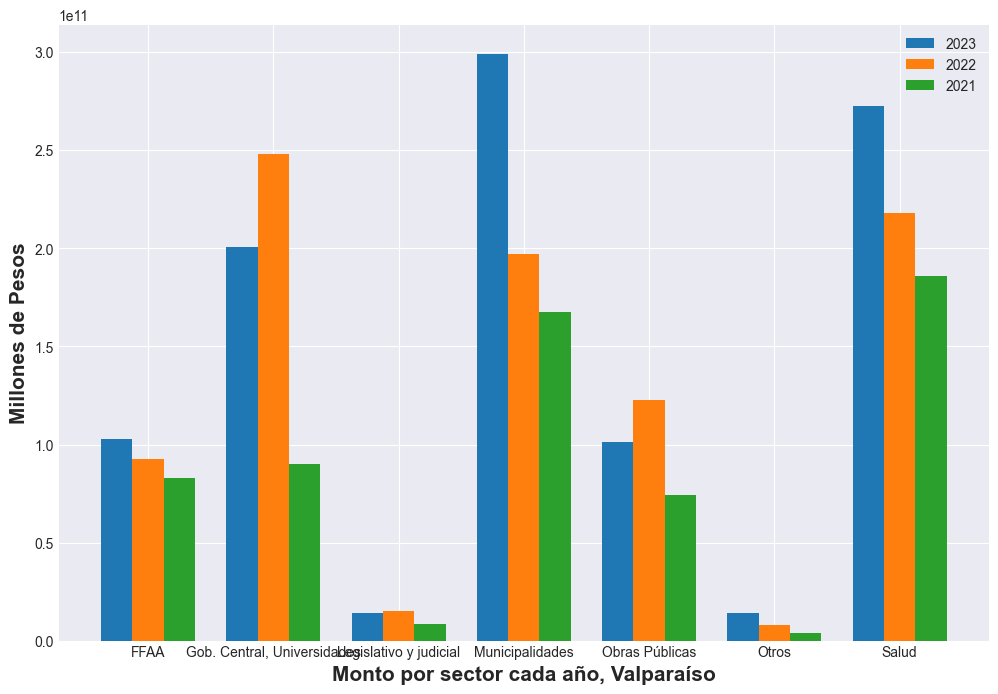

In [11]:
###################################################
###   Llenado diccionario/contexto y template   ###
###################################################

#Importar template
docu = DocxTemplate("docxtpl.docx")

#Settear diccionario nacional
contextoNac = {'ano' : str(anoReg),
               'anoM' : str(anoRegM),
               'mesI' : meses[mes_i - 1],   #llama nombre del mes para usar en reporte
               'mesF' : meses[mes_f - 1]}

#settear diccionario adicionales regionales
adicionalesReg = impAdicionalesReg()



#prepara dataframe para gráficos de sector por región por año (se crea y agrega en iterador de regiones)
    #y sector por región nacional (se crea y agrega antes de iterador de regiones)

#filta año actual para gráfico sector por región nacional
dfSectorReg = dfSecRegAnos.loc[dfSecRegAnos['Ano'] == 2023]

#crea  diccionario para gráfico sector por región nacional
dcSectorReg = diccionarioGraficos(dfSectorReg, listReg, 'Region', listSectores, 'Sec')



#Crea gráfico
tituloGrafSecRegNac = 'Sector por región, nivel nacional'
graficoSectoresRegion(dcSectorReg, listSectores, tituloGrafSecRegNac)

#agrega gráfico al diccionario
img = InlineImage(docu, tituloGrafSecRegNac+'.png',width=Inches(7))
contextoNac.update({'secRegNacGrf' : img})


#diccionario que almacena los diccionarios de cada región para luego exportar una planilla con todos los datos
dicGlob = {}



#Iterador de regiones/documentos
for r in listReg:
    print('')
    print('##############')
    print(r)
    print('##############')

    contexto = setContextoReg(r, RegNomb)

    rTotReg = TotReg.loc[TotReg['Region'] == r]
    contexto.update(agregarTotalesRegion(rTotReg))

    #tmn Reg
    rTmnReg = extraerDataframe (TotRegBig, r, listColTmnReg)
    rTmnReg = fmtoDataframe(rTmnReg, listColTmnReg)
    contexto.update(dataframeDiciconario(rTmnReg, dtoTmnReg))

    #modalidad de compra
    rModReg = extraerDataframe (TotRegBig, r, listColModReg)
    rModReg = fmtoDataframe(rModReg, listColModReg)    
    contexto.update(dataframeDiciconario(rModReg, dtoModReg))

    
    # proveedores a los que se le compra por región
    rPrvReg = extraerDataframe (TotRegBig, r, listColPrvReg)
    rPrvReg = fmtoDataframe(rPrvReg, listColPrvReg) 
    contexto.update(dataframeDiciconario(rPrvReg, dtoPrvReg))

    # top Instituciones reg
    rInsReg = extraerDataframe (TotRegBig, r, listColInsReg)
    rInsReg = fmtoDataframe(rInsReg, listColInsReg)    
    contexto.update(dataframeDiciconario(rInsReg, dtoInsReg))

    #top rubro por region (usa dataframe personalizado)
    
    RubReg.to_excel('rubroRegion.xlsx')
    rRubReg = extraerDataframe(RubReg, r, listColRubReg)
    rRubReg = fmtoDataframe(rRubReg, listColRubReg)
    
    ttlGrafRub = 'Rubros más transados, '+ RegNomb[r]['nomCt']+' (Millones de Pesos)'
    grafBarras((np.array(rRubReg['CLP'])/1000000), rRubReg[''], ttlGrafRub)
    img = InlineImage(docu, ttlGrafRub+'.png',width=Inches(7))
    contexto.update({'rubRegGrf' : img})

    #no lo pide ahora comunicaciones
    #contexto.update(dataframeDiciconario(rRubReg, dtoRubReg, topRubReg))
    
    rOCReg = extraerDataframe(TotRegBig, r, listColOCReg)
    rOCReg = fmtoDataframe(rOCReg, listColOCReg)
    contexto.update(dataframeDiciconario(rOCReg, dtoOCReg))

    rSecReg = extraerDataframe(TotRegBig, r, listColSecReg)
    rSecReg = fmtoDataframe(rSecReg, listColSecReg)
    contexto.update(dataframeDiciconario(rSecReg, dtoSecReg))

    ttlGrafSec = 'Porcentaje participación por Sector, '+ RegNomb[r]['nomCt']
    grafTorta(rSecReg['CLP'], rSecReg[''], ttlGrafSec)
    img = InlineImage(docu, ttlGrafSec+'.png',width=Inches(7))
    contexto.update({'secRegGrf' : img})

    dfSectorAno = dfSecRegAnos.loc[dfSecRegAnos['Region'] == r]
    dcSectorAno = diccionarioGraficos(dfSectorAno, listaAnos, 'Ano', listSectores, 'Sec')
    tituloGrafBarra3 = 'Monto por sector cada año, '+ RegNomb[r]['nomCt']
    grafBarrasTriple(dcSectorAno, listaAnos, listSectores, tituloGrafBarra3)
    img = InlineImage(docu, tituloGrafBarra3+'.png',width=Inches(7))
    contexto.update({'secRegAnoGrf' : img})

    rCAReg = CAReg.loc[CAReg['Region'] == r]
    contexto.update(agregarCARegion(rCAReg))

    contexto.update(adicionalesReg[r])

    contexto.update(contextoNac)
    
    
    print(contexto)
    dicGlob.update({r: contexto})

    docu.render(contexto)
    #os.remove(titGrafSecReg +'.png')    #según cantidad de gráficos se podría iterar
    
    nomDocu = contexto['ano'] + ' cifras regionales ' + contexto['nomCt'] + ' ' + contexto['mesI'] + '-' + contexto['mesF']
    docu.save('reportes/'+nomDocu+'.docx')

In [12]:
#######################################################
# Exporta planilla con todos los contextos regionales #
#######################################################

dfGlob = pd.DataFrame(dicGlob)
dfGlob.to_excel('dfGlob.xlsx')

In [13]:
#############################
# Borar gráficos de carptea #
#############################


os.remove('Sector por región, nivel nacional'+'.png')
for r in listReg:
    
    os.remove('Monto por sector cada año, '+ RegNomb[r]['nomCt']+'.png')
    os.remove('Rubros más transados, '+ RegNomb[r]['nomCt']+' (Millones de Pesos)' +'.png')   
    os.remove('Porcentaje participación por Sector, '+ RegNomb[r]['nomCt'] +'.png')   